In [74]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import datetime

def days_between(d1, d2):
    d1 = d1.strftime("%Y-%m-%d")
    d2 = d2.strftime("%Y-%m-%d")
    return abs((d2 - d1).days)

cols1 = ['country','age','date_hospitalised','date_death','date_recovered','date_onset','date_first_consultation']
cols2 = ['sex','birth_year','country','exposure_start','confirmed_date','released_date','deceased_date']
cols3 = ['Age','Gender','Nationality','Symptomatic ToConfirmation','Days ToRecover']
cols1_rename = ['country','age','hospit_date','death_date','rec_date','onset_date','confirm_date']
cols2_rename = ['sex', 'birth_year', 'country', 'exposure_start','confirm_date','releas_date','decease_date']
cols3_rename = ['age', 'sex', 'country', 'sympt_to_confirm', 'confirm_to_release']

data1 = pd.read_csv(r"data/subset_international_cases_2020_03_11.csv", usecols=cols1)
data2 = pd.read_csv(r"data/patients.csv", usecols=cols2)
data3 = pd.read_csv(r"data/data (30).csv", usecols=cols3)

data1 = data1.rename(columns={k:v for k,v in zip(cols1,cols1_rename)})
data2 = data2.rename(columns={k:v for k,v in zip(cols2,cols2_rename)})
data3 = data3.rename(columns={k:v for k,v in zip(cols3,cols3_rename)})
cols1 = cols1_rename
cols2 = cols2_rename
cols3 = cols3_rename

# data 1
for col in cols1[2:]:
    data1[col] = pd.to_datetime(data1[col], format='%d/%m/%Y')
    
data1['onset_to_confirm'] = (data1['confirm_date']-data1['onset_date']).dt.days
data1['hospit_to_decease'] = (data1['death_date']-data1['hospit_date']).dt.days
data1['hospit_to_release'] = (data1['rec_date']-data1['hospit_date']).dt.days
data1 = data1.drop(columns=['hospit_date', 'death_date', 'rec_date', 'onset_date', 'confirm_date'])
data1.loc[data1['hospit_to_decease'].notna()]

# data 2
data2['age'] = 2020 - data2['birth_year']
for col in cols2[3:]:
    data2[col] = pd.to_datetime(data2[col])
data2['expose_to_confirm'] = (data2['confirm_date']-data2['exposure_start']).dt.days
data2['confirm_to_release'] = (data2['releas_date']-data2['confirm_date']).dt.days
data2['confirm_to_decease'] = (data2['decease_date']-data2['confirm_date']).dt.days
data2 = data2.drop(columns=['birth_year', 'exposure_start', 'confirm_date', 'confirm_date', 'releas_date', 'decease_date'])
data2 = data2.loc[data2['country'] == 'Korea']
data2 = data2.replace('Korea', 'South Korea')

# data 3
data3 = data3.loc[data3['country'] == 'Taiwanese']  # in Taiwan: confirm = hospital
data3 = data3.replace('Taiwanese', 'Taiwan')
data3['sex'] = data3['sex'].str.lower()

print(data1['country'].unique())
print(data2['country'].unique())
print(data3['country'].unique())

data1 = data1.loc[data1['onset_to_confirm'].notna()]      # 173 cases
# data1 = data1.loc[data1['hospit_to_release'].notna()]     # 51 cases
# data1 = data1.loc[data1['hospit_to_decease'].notna()]     # only 6 cases

data2 = data2.loc[data2['expose_to_confirm'].notna()]     # 352 cases
# data2 = data2.loc[data2['confirm_to_release'].notna()]    # 50 cases   # in Taiwan: confirm = hospital
# data2 = data2.loc[data2['confirm_to_decease'].notna()]    # 35 cases

data3 = data3.loc[data3['sympt_to_confirm'].notna()]      # 275 cases
# data3 = data3.loc[data3['confirm_to_release'].notna()]    # only 9 cases  # otherwise isolated


data2 = data2.loc[data2['expose_to_confirm'] >= 0]

['Japan' 'Singapore' 'South Korea' 'HK SAR']
['South Korea']
['Taiwan']


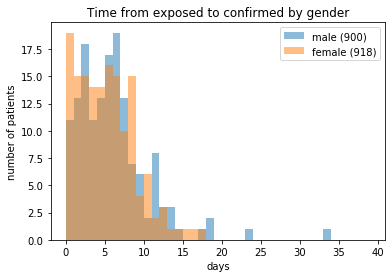

In [84]:
male = data2.loc[data2['sex'] == 'male']
female = data2.loc[data2['sex'] == 'female']

plt.title('Time from exposed to confirmed')
plt.xlabel('days')
plt.ylabel('number of patients')

for gender, label in zip([male, female], ['male', 'female']):
    plt.hist(gender['expose_to_confirm'], bins=np.arange(0,40,1), alpha=0.5, label=label+' ('+str(gender.size)+')')

plt.legend()

plt.title('Time from exposed to confirmed by gender')
plt.xlabel('days')
plt.ylabel('number of patients')
plt.savefig('figures/exp_to_conf-genders.png')

(0, 25) 39
(25, 40) 73
(40, 60) 93
(60, 70) 45
(70, 200) 22


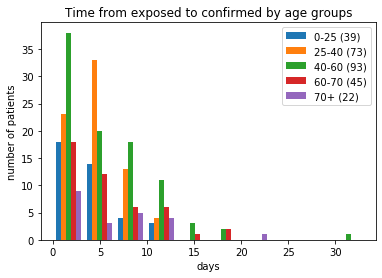

In [82]:
from ages_module import parse_age_groups_i

# age_groups = [(0,10),(10,20),(20,30),(30,40),(40,50),(50,60),(60,70),(70,200)]
age_groups = [(0,25),(25,40),(40,60),(60,70),(70,200)]

data_age_groups = []
for age_group in age_groups:
    this_age_group = data2['expose_to_confirm'].loc[(data2['age'] > age_group[0]) & (data2['age'] < age_group[1])]
    data_age_groups.append(this_age_group)
    print(age_group, this_age_group.size)

data_groups = np.array(data_age_groups)
data_age_groups_labels = parse_age_groups_i(age_groups)
for i, label in enumerate(data_age_groups_labels):
    data_age_groups_labels[i] = label+' ('+str(data_groups[i].size)+')'
plt.hist(data_groups, label=data_age_groups_labels)

plt.legend()

plt.title('Time from exposed to confirmed by age groups')
plt.xlabel('days')
plt.ylabel('number of patients')
plt.savefig('figures/exp_to_conf-agegroups.png')

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
         rec       die
0   0.000000  0.000000
1   0.023333  0.010000
2   0.060000  0.020000
3   0.100000  0.040000
4   0.130000  0.070000
5   0.156667  0.080000
6   0.193333  0.110000
7   0.226667  0.140000
8   0.260000  0.160000
9   0.303333  0.190000
10  0.343333  0.220000
11  0.376667  0.250000
12  0.406667  0.260000
13  0.430000  0.280000
14  0.460000  0.300000
15  0.483333  0.320000
16  0.506667  0.320000
17  0.533333  0.340000
18  0.556667  0.350000
19  0.566667  0.360000
20  0.583333  0.370000
21  0.596667  0.370000
22  0.600000  0.376667


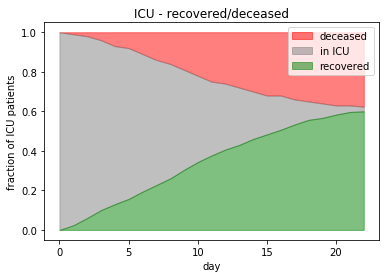

In [155]:
data4 = pd.read_csv(r"data/survival_ICU_2.csv")
data4 = data4.rename(columns={k:v for k,v in zip(['day', 'percent recovered', 'percent died'],['day','rec','die'])})
data4 = data4.loc[:, ['rec','die']] / 100
days = np.arange(0, len(data4))

print(days)
print(data4)
# plt.plot(days, data4['rec'], '.-', color='b')
# plt.plot(days, 1-data4['die'], '.-', color='r')

plt.fill_between(days, 1-data4['die'], np.ones_like(data4['die']), color='r', alpha=0.5, label='deceased')
plt.fill_between(days, data4['rec'], 1-data4['die'], color='grey', alpha=0.5, label='in ICU')
plt.fill_between(days, np.zeros_like(data4['rec']), data4['rec'], color='g', alpha=0.5, label='recovered')

plt.legend()
plt.xlabel('day')
plt.ylabel('fraction of ICU patients')
plt.title('ICU - recovered/deceased')

plt.savefig('figures/ICU_patients.png')